In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Physics parameters 
Te = 3          # Constant electron temperature
A0 = 1/np.pi
eta= 1.0e-8

# Numerical settings
l  = 3*np.sqrt(2)
L  = np.sqrt(2) # Length of the simulation region
n  = 200        # numebr of grids
ng = 2          # number of ghost grids for 5-points central scheme
h  = l/n        # unit size 
T  = 3.0        # simulation time
nt = 3000        # number of time steps
dt = T/nt       # time step

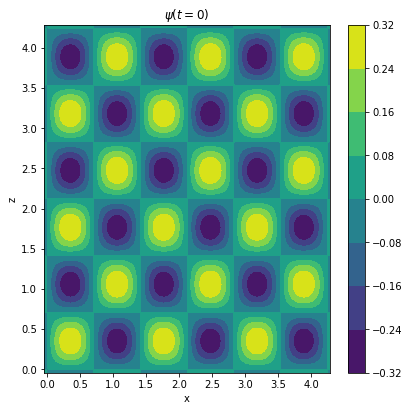

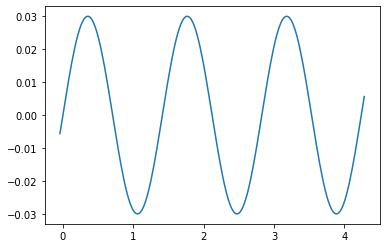

In [4]:
# Initial condition
rho1 = np.ones([n+2*ng+1, n+2*ng+1])  # Initial density
vx1  = np.zeros([n+2*ng+1, n+2*ng+1])
vz1  = np.zeros([n+2*ng+1, n+2*ng+1])
psi1 = np.zeros([n+2*ng+1, n+2*ng+1])

for i in range(n+1):
    for j in range(n+1):
        x = j*h 
        z = i*h 
        psi1[i+2,j+2] = A0*np.sin(2*np.pi*x/L)*np.sin(2*np.pi*z/L)

# Doubly-preriodic BC  
# Left 
rho1[:,0]  = rho1[:,-5]  
rho1[:,1]  = rho1[:,-4]  
psi1[:,0]  = psi1[:,-5] 
psi1[:,1]  = psi1[:,-4]
vx1[:,0]   = vx1[:,-5]  
vx1[:,1]   = vx1[:,-4]  
vz1[:,0]   = vz1[:,-5] 
vz1[:,1]   = vz1[:,-4]
# Right 
rho1[:,-2] = rho1[:,3]
rho1[:,-1] = rho1[:,4]
psi1[:,-2] = psi1[:,3]
psi1[:,-1] = psi1[:,4]
vx1[:,-2]  = vx1[:,3]
vx1[:,-1]  = vx1[:,4]
vz1[:,-2]  = vz1[:,3]
vz1[:,-1]  = vz1[:,4]
# Top
rho1[0]    = rho1[-5]
rho1[1]    = rho1[-4]
psi1[0]    = psi1[-5]
psi1[1]    = psi1[-4]
vx1[0]     = vx1[-5]
vx1[1]     = vx1[-4]
vz1[0]     = vz1[-5]
vz1[1]     = vz1[-4]
# Bottom 
rho1[-2]   = rho1[3]
rho1[-1]   = rho1[4]
psi1[-2]   = psi1[3]
psi1[-1]   = psi1[4]
vx1[-2]    = vx1[3]
vx1[-1]    = vx1[4]
vz1[-2]    = vz1[3]
vz1[-1]    = vz1[4]

plt.figure(figsize=[6.4,6.4])
x = np.linspace(0-2*h, l+2*h, n+5)
z = np.linspace(0-2*h, l+2*h, n+5)
cont = plt.contourf(x, z, psi1)
cbar = plt.colorbar(cont)
plt.xlabel('x')
plt.ylabel('z')
plt.title(r'$\psi(t=0)$')
#plt.savefig('psi0_triple.png')

plt.figure()
plt.plot(z, psi1[:,3])

In [5]:
# 1st-order partial derivatives
def px(f, dx):
    return (-f[2:-2,4:]+8*f[2:-2,3:-1]-8*f[2:-2,1:-3]+f[2:-2,:-4]) / (12*dx)

def pz(f, dz):
    return (-f[4:,2:-2]+8*f[3:-1,2:-2]-8*f[1:-3,2:-2]+f[:-4,2:-2]) / (12*dz)

# 2nd-order partial derivatives
def pxx(f, dx):
    return (-f[2:-2,4:]+16*f[2:-2,3:-1]-30*f[2:-2,2:-2]+16*f[2:-2,1:-3]-f[2:-2,:-4]) / (12*dx**2)

def pzz(f, dz):
    return (-f[4:,2:-2]+16*f[3:-1,2:-2]-30*f[2:-2,2:-2]+16*f[1:-3,2:-2]-f[:-4,2:-2]) / (12*dz**2)

In [6]:
def f_rho(rho, vx, vz, dx, dz, dt, k):
    s1 = - np.multiply(rho[2:-2,2:-2], px(vx,dx)+pz(vx,dz))
    a1 = px(vx,dx)
    a2 = pz(vx,dz)
    
    if (k%50==0):
        print('px:', a1[0,0], 'pz:', a2[0,0])     
        plt.figure(figsize=[6.4,9.6])
        x = np.linspace(0, np.sqrt(2), 201)
        z = np.linspace(0, np.sqrt(2), 201)
        plt.subplot(211)
        plt.plot(x, a1[2], label=r'$\frac{\partial v_x}{\partial x}$')
        plt.plot(x, a2[2], label=r'$\frac{\partial v_x}{\partial z}$')
        plt.xlabel('x', fontsize=24)
        plt.title('t='+str(k*dt), fontsize=24)
        plt.legend(fontsize=18)
        plt.subplot(212)
        plt.plot(z, a1[:,2], label=r'$\frac{\partial v_x}{\partial x}$')
        plt.plot(z, a2[:,2], label=r'$\frac{\partial v_x}{\partial z}$')
        plt.xlabel('z', fontsize=24)
        plt.legend(fontsize=18)
        plt.tight_layout()
        plt.savefig('oscillation1_triple_'+str(k)+'.png')
    
    s2 = - np.multiply(vx[2:-2,2:-2], px(rho,dx)) - np.multiply(vz[2:-2,2:-2], pz(rho,dz))
    return (s1+s2)*dt

def f_vx(rho, vx, vz, psi, dx, dz, dt):
    s1 = - np.multiply(vx[2:-2,2:-2], px(vx,dx)) - np.multiply(vz[2:-2,2:-2], pz(vx,dz))
    s2 = - np.divide(2*Te*px(rho,dx), rho[2:-2,2:-2])
    s3 = - np.divide(np.multiply(px(psi,dx), pxx(psi,dx)+pzz(psi,dz)), rho[2:-2,2:-2])
    return (s1+s2+s3)*dt

def f_vz(rho, vx, vz, psi, dx, dz, dt):
    s1 = - np.multiply(vx[2:-2,2:-2], px(vz,dx)) - np.multiply(vz[2:-2,2:-2], pz(vz,dz))
    s2 = - np.divide(2*Te*pz(rho,dz), rho[2:-2,2:-2])
    s3 = - np.divide(np.multiply(pz(psi,dz), pxx(psi,dx)+pzz(psi,dz)), rho[2:-2,2:-2])
    return (s1+s2+s3)*dt

def f_psi(vx, vz, psi, dx, dz, dt):
    s1 = - np.multiply(vx[2:-2,2:-2], px(psi,dx)) - np.multiply(vz[2:-2,2:-2], pz(psi,dz))
    s2 = eta * (pxx(psi,dx)+pzz(psi,dz))
    return (s1+s2)*dt

0
vx: 0.004442867373628668 vz: 0.004442867373628627
px: 0.0 pz: 1.6296528062195963e-16
rho: 1.0000394766250393 0.0
psi: 0.3183098860581271 0.3183098860581271
1
vx: 0.004441639658910875 vz: 0.10990895250167615
rho: 1.0000789454542165 0.9999153040264995
psi: 0.3183098859324536 0.3183098859324536
2
vx: 0.004440587737911779 vz: 0.10853545935172772
rho: 1.000118409599597 0.9998730168258341
psi: 0.31830988580676023 0.31830988580676023
3
vx: 0.004439711579601244 vz: 0.10595469941859371
rho: 1.000157872170792 0.9998307695342935
psi: 0.3183098856810371 0.3183098856810371
4
vx: 0.004439011229298032 vz: 0.10220697699012062
rho: 1.0001973362776593 0.9997885617416534
psi: 0.31830988555527423 0.31830988555527423
5
vx: 0.004438486808781248 vz: 0.09734419792697319
rho: 1.0002368050330015 0.9997463930403646
psi: 0.31830988542946165 0.31830988542946165
6
vx: 0.0044381385164808445 vz: 0.09142864502001202
rho: 1.0002762815552693 0.9997042630254704
psi: 0.31830988530358933 0.31830988530358933
7
vx: 0.00443

vx: 0.004785760205032576 vz: 0.5239739746414652
rho: 1.002663638361566 0.9973544990494961
psi: 0.3183098776180944 0.3183098776180944
64
vx: 0.004801835937723653 vz: 0.5311238112629252
rho: 1.0027110451186936 0.9973139747418178
psi: 0.3183098774636617 0.3183098774636617
65
vx: 0.004818394163946876 vz: 0.5381868458476007
rho: 1.0027588125486562 0.9972734675970868
psi: 0.3183098773079562 0.3183098773079562
66
vx: 0.004835448734686283 vz: 0.5451602632244779
rho: 1.0028069552261951 0.9972329772622637
psi: 0.31830987715092546 0.31830987715092546
67
vx: 0.004853014120508013 vz: 0.5521494262170128
rho: 1.002855488449426 0.9971925033839694
psi: 0.3183098769925144 0.3183098769925144
68
vx: 0.004871105443622929 vz: 0.5592644503468878
rho: 1.002904428289228 0.997152045608456
psi: 0.31830987683266493 0.31830987683266493
69
vx: 0.004889738511980964 vz: 0.5662893792055934
rho: 1.0029537916426838 0.9971116035815778
psi: 0.3183098766713158 0.3183098766713158
70
vx: 0.004908929855537164 vz: 0.5732212477

rho: 1.0129023697927633 0.9947000608922968
psi: 0.3183098550303441 0.3183098550303441
130
vx: 0.015325641466445357 vz: 1.2884368663677637
rho: 1.0134774588092195 0.9946598765873154
psi: 0.3183098540421214 0.3183098540421214
131
vx: 0.01606360561020535 vz: 1.3624921479395726
rho: 1.014077357350813 0.9946196841561598
psi: 0.31830985300618764 0.31830985300618764
132
vx: 0.016844200911385505 vz: 1.4419779421858265
rho: 1.0147020354279848 0.9945794831644593
psi: 0.3183098519211168 0.3183098519211168
133
vx: 0.01767118646271309 vz: 1.527594758063879
rho: 1.015351420907889 0.9945392731756777
psi: 0.31830985078563323 0.31830985078563323
134
vx: 0.01853756076591817 vz: 1.6201944311339727
rho: 1.0160547723791142 0.9944624997505154
psi: 0.3183098495986388 0.3183098495986388
135
vx: 0.01944316741256562 vz: 1.720816509541672
rho: 1.0168034187855244 0.9939672993660575
psi: 0.3183098483592418 0.3183098483592418
136
vx: 0.02038754319431527 vz: 1.8307344597130721
rho: 1.0175813724914027 0.9934243719359

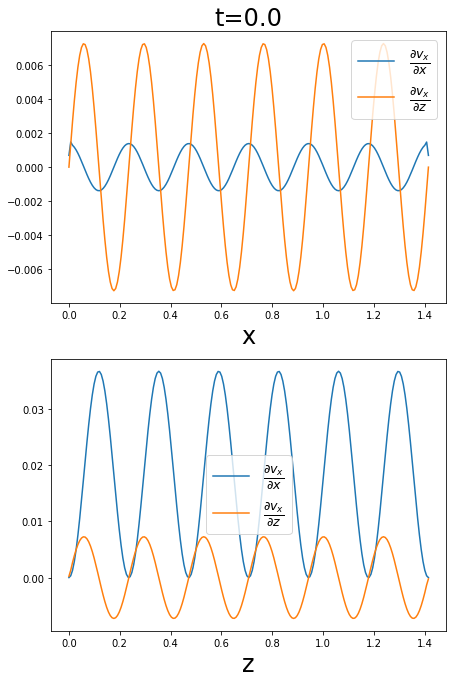

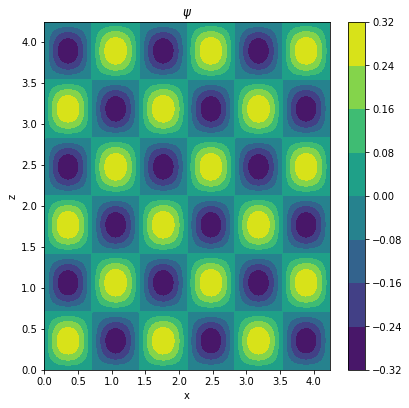

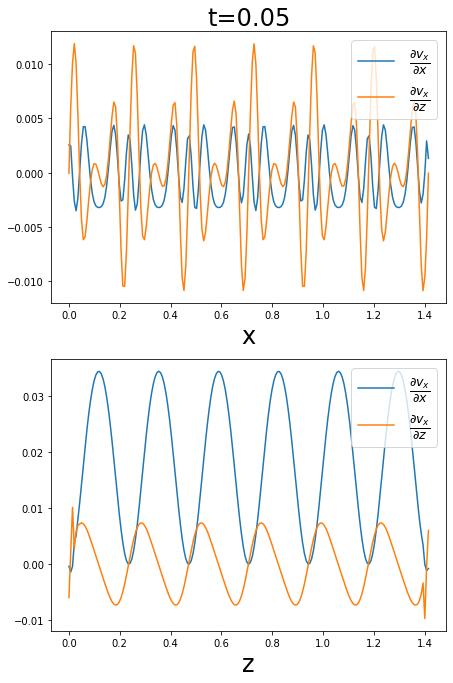

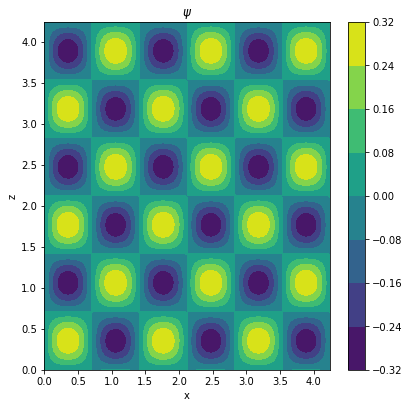

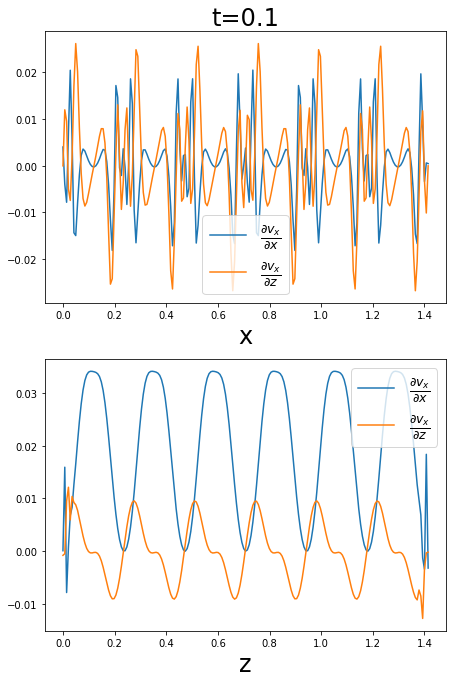

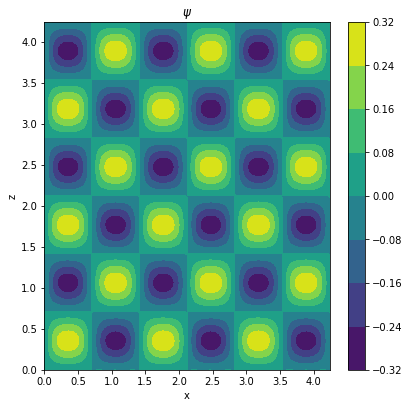

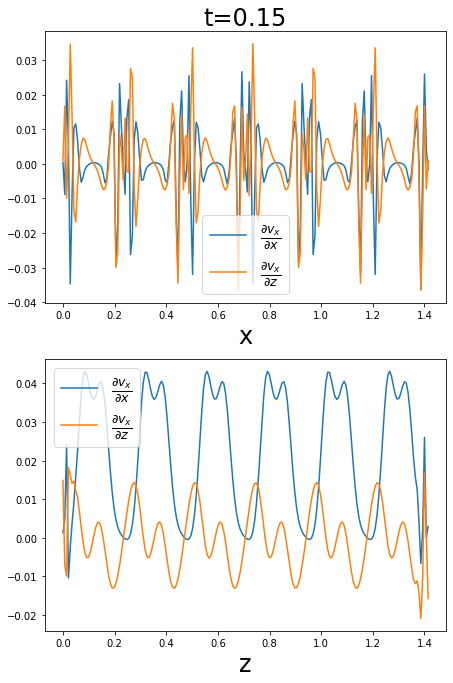

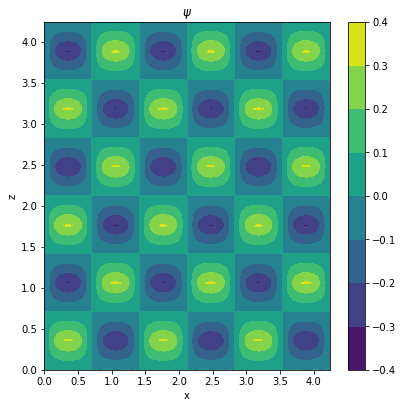

In [7]:
# Verlet Stepper
vxtpr = np.zeros([n+2*ng+1, n+2*ng+1]) # temporary array at n+1/2
vztpr = np.zeros([n+2*ng+1, n+2*ng+1]) # temporary array at n+1/2
vx2   = np.zeros([n+2*ng+1, n+2*ng+1]) # updated array at n+1
vz2   = np.zeros([n+2*ng+1, n+2*ng+1]) # updated array at n+1
rho2  = np.zeros([n+2*ng+1, n+2*ng+1]) # updated array at n+1
psi2  = np.zeros([n+2*ng+1, n+2*ng+1]) # updated array at n+1

for k in range(151):
    print(k)
    vztpr[2:-2,2:-2] = vz1[2:-2,2:-2] + f_vz(rho1, vx1, vz1, psi1, h, h, dt*0.5)
    vxtpr[2:-2,2:-2] = vx1[2:-2,2:-2] + f_vx(rho1, vx1, vz1, psi1, h, h, dt*0.5)
    print('vx:', np.amax(vxtpr), 'vz:', np.amax(vztpr))
    
    rho2[2:-2,2:-2] = rho1[2:-2,2:-2] + f_rho(rho1, vxtpr, vztpr, h, h, dt, k)
    psi2[2:-2,2:-2] = psi1[2:-2,2:-2] + f_psi(vxtpr, vztpr, psi1, h, h, dt)
    print('rho:', np.amax(rho2), np.amin(rho2))
    print('psi:', np.amax(psi2), np.amax(psi2))
    
    vz2[2:-2,2:-2] = vztpr[2:-2,2:-2] + f_vz(rho2, vxtpr, vztpr, psi2, h, h, dt*0.5)
    vx2[2:-2,2:-2] = vxtpr[2:-2,2:-2] + f_vx(rho2, vxtpr, vztpr, psi2, h, h, dt*0.5)
    
    # Left 
    rho2[:,0]  = rho2[:,-5]  
    rho2[:,1]  = rho2[:,-4]  
    psi2[:,0]  = psi2[:,-5] 
    psi2[:,1]  = psi2[:,-4]
    vx2[:,0]   = vx2[:,-5]  
    vx2[:,1]   = vx2[:,-4]  
    vz2[:,0]   = vz2[:,-5] 
    vz2[:,1]   = vz2[:,-4]
    # Right 
    rho2[:,-2] = rho2[:,3]
    rho2[:,-1] = rho2[:,4]
    psi2[:,-2] = psi2[:,3]
    psi2[:,-1] = psi2[:,4]
    vx2[:,-2]  = vx2[:,3]
    vx2[:,-1]  = vx2[:,4]
    vz2[:,-2]  = vz2[:,3]
    vz2[:,-1]  = vz2[:,4]
    # Top
    rho2[0]    = rho2[-5]
    rho2[1]    = rho2[-4]
    psi2[0]    = psi2[-5]
    psi2[1]    = psi2[-4]
    vx2[0]     = vx2[-5]
    vx2[1]     = vx2[-4]
    vz2[0]     = vz2[-5]
    vz2[1]     = vz2[-4]
    # Bottom 
    rho2[-2]   = rho2[3]
    rho2[-1]   = rho2[4]
    psi2[-2]   = psi2[3]
    psi2[-1]   = psi2[4]
    vx2[-2]    = vx2[3]
    vx2[-1]    = vx2[4]
    vz2[-2]    = vz2[3]
    vz2[-1]    = vz2[4]
    
    # Update the result
    rho1 = rho2
    vx2  = vx2
    vz1  = vz2
    psi1 = psi2
    
    if (k%50==0):
        x = np.linspace(0, l, n+1)
        z = np.linspace(0, l, n+1)
        plt.figure(figsize=[6.4,6.4])
        cont = plt.contourf(x, z, psi1[2:-2,2:-2])
        cbar = plt.colorbar(cont)
        plt.xlabel('x')
        plt.ylabel('z')
        plt.title(r'$\psi$')
        plt.savefig('psi1_'+str(k)+'.png')
    

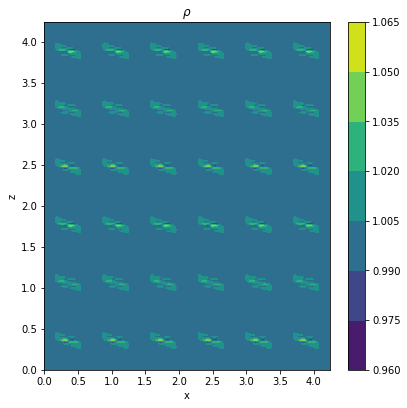

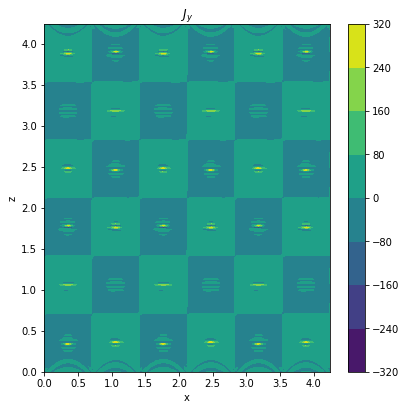

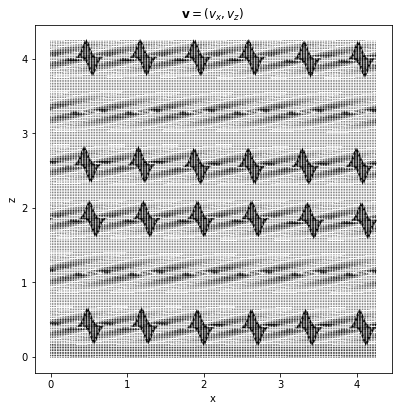

In [61]:
x = np.linspace(0, l, n+1)
z = np.linspace(0, l, n+1)

plt.figure(figsize=[6.4,6.4])
cont = plt.contourf(x, z, rho1[2:-2,2:-2])
cbar = plt.colorbar(cont)
plt.xlabel('x')
plt.ylabel('z')
plt.title(r'$\rho$')
plt.savefig('rho_triple'+str(k)+'.png')

jy = pxx(psi1,h) + pzz(psi1,h)
plt.figure(figsize=[6.4,6.4])
cont = plt.contourf(x, z, jy)
cbar = plt.colorbar(cont)
plt.xlabel('x')
plt.ylabel('z')
plt.title(r'$J_y$')
#plt.savefig('jy_triple'+str(k)+'.png')

X, Z = np.meshgrid(x,z)
plt.figure(figsize=[6.4,6.4])
plt.quiver(X, Z, vx1, vz1)
plt.xlabel('x')
plt.ylabel('z')
plt.title(r'$\mathbf{v}=(v_x,v_z)$')
plt.savefig('v_triple'+str(k)+'.png')

px: 0.0 pz: 3.2593056124391926e-16
rho: 1.0000789532500785 0.0
psi: 0.3183098860581271 0.3183098860581271


0
rho: 1.0001578753177525 0.9998371722517903
psi: 0.31830988593244364 0.31830988593244364


rho: 1.0002367724044885 0.9997591995594595
psi: 0.3183098858067304 0.3183098858067304


rho: 1.0003156506976103 0.9996813142110034
psi: 0.3183098856809775 0.3183098856809775


rho: 1.0003945163757029 0.9996035159476491
psi: 0.3183098855551749 0.3183098855551749


rho: 1.0004733756139899 0.9995258046874086
psi: 0.3183098854293127 0.3183098854293127


rho: 1.000552234589696 0.9994481803297033
psi: 0.3183098853033808 0.3183098853033808


rho: 1.0006310994874055 0.9993706427544806
psi: 0.31830988517736913 0.31830988517736913


rho: 1.000709976504428 0.9992927673071941
psi: 0.31830988505126756 0.31830988505126756


rho: 1.0007888718561835 0.9992146469299773
psi: 0.3183098849250659 0.3183098849250659


rho: 1.0008677917816147 0.9991366177173878
psi: 0.3183098847987539 0.3183098847987539


rho: 1

rho: 1.0100961915756013 0.9924175609934288
psi: 0.31830987025389473 0.31830987025389473


100
rho: 1.010325597448353 0.992345205162893
psi: 0.31830986996900074 0.31830986996900074


rho: 1.0105638944277306 0.9922728700571923
psi: 0.3183098696753556 0.3183098696753556


rho: 1.0108114888056314 0.992200554483828
psi: 0.31830986937236644 0.31830986937236644


rho: 1.011068784505546 0.9921282572389609
psi: 0.3183098690593959 0.3183098690593959


rho: 1.0113361793898092 0.9920559771072339
psi: 0.31830986873575906 0.31830986873575906


rho: 1.0116194948125377 0.9919837128615897
psi: 0.31830986840072056 0.31830986840072056


rho: 1.011926628910138 0.9919114632630814
psi: 0.3183098680534919 0.3183098680534919


rho: 1.0122468867361034 0.9918392270606778
psi: 0.3183098676932283 0.3183098676932283


rho: 1.0125807555391304 0.9917670029910619
psi: 0.31830986731902633 0.31830986731902633


rho: 1.0129287001331815 0.991694789778423
psi: 0.3183098669299211 0.3183098669299211


rho: 1.013291156293938

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in multiply
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in multiply
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in multiply
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in add
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in add
  This is separate from the ipykernel package so we can avoid doing imports until
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in subtract
  This is separate from the ipykernel package so we can avoid doing imports until
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.

rho: nan nan
psi: nan nan


rho: nan nan
psi: nan nan


rho: nan nan
psi: nan nan


rho: nan nan
psi: nan nan


rho: nan nan
psi: nan nan


rho: nan nan
psi: nan nan


rho: nan nan
psi: nan nan


rho: nan nan
psi: nan nan


rho: nan nan
psi: nan nan


rho: nan nan
psi: nan nan


rho: nan nan
psi: nan nan


rho: nan nan
psi: nan nan


rho: nan nan
psi: nan nan


rho: nan nan
psi: nan nan


rho: nan nan
psi: nan nan


rho: nan nan
psi: nan nan


rho: nan nan
psi: nan nan


rho: nan nan
psi: nan nan


rho: nan nan
psi: nan nan


rho: nan nan
psi: nan nan


rho: nan nan
psi: nan nan


rho: nan nan
psi: nan nan


rho: nan nan
psi: nan nan


rho: nan nan
psi: nan nan


rho: nan nan
psi: nan nan


rho: nan nan
psi: nan nan


rho: nan nan
psi: nan nan


rho: nan nan
psi: nan nan


rho: nan nan
psi: nan nan


rho: nan nan
psi: nan nan


rho: nan nan
psi: nan nan


rho: nan nan
psi: nan nan


rho: nan nan
psi: nan nan




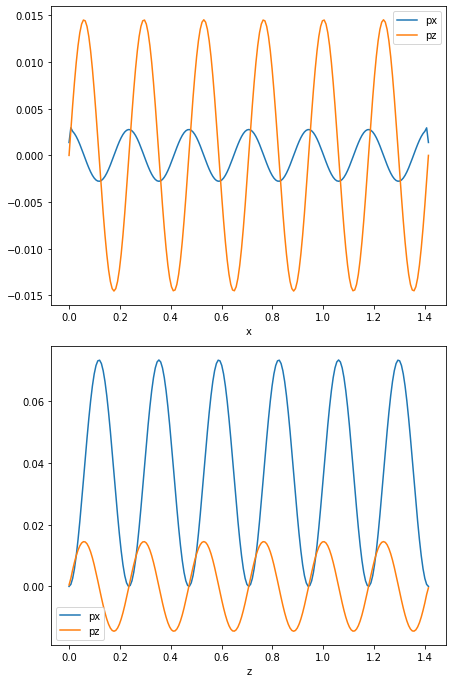

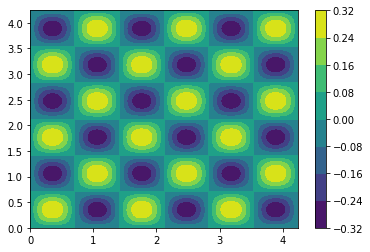

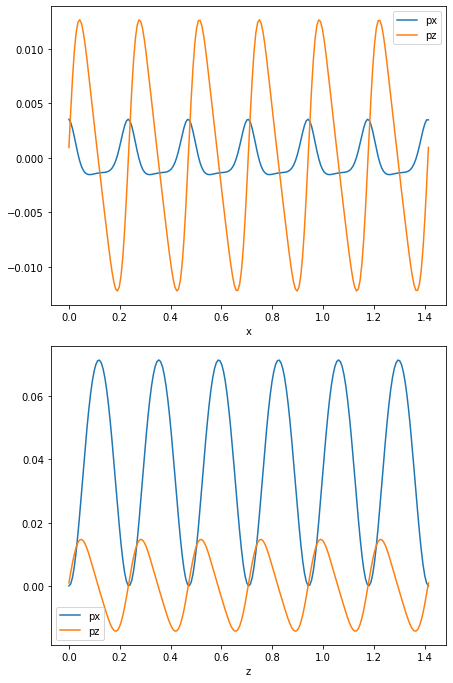

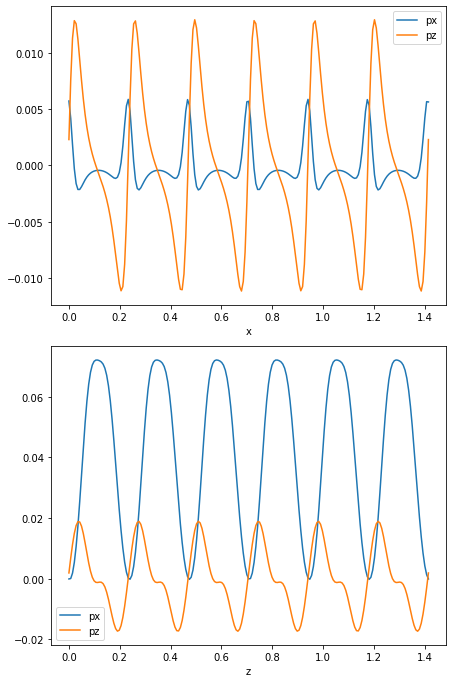

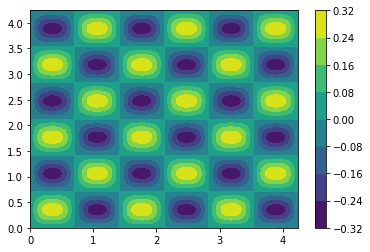

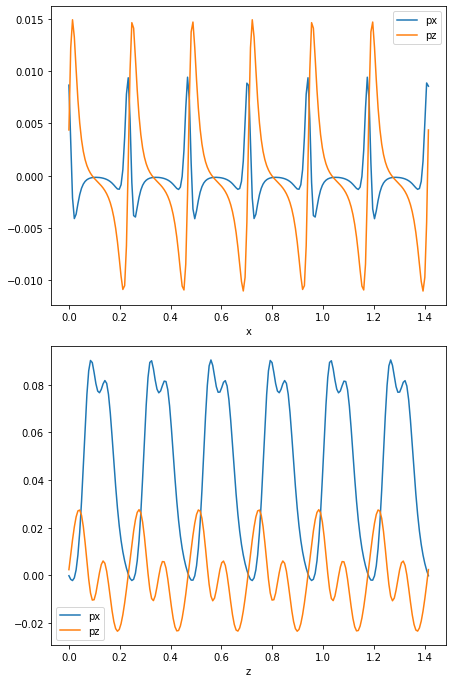

In [59]:
# Symplectic Euler Stepper
vx2   = np.zeros([n+2*ng+1, n+2*ng+1]) # updated array at n+1
vz2   = np.zeros([n+2*ng+1, n+2*ng+1]) # updated array at n+1
rho2  = np.zeros([n+2*ng+1, n+2*ng+1]) # updated array at n+1
psi2  = np.zeros([n+2*ng+1, n+2*ng+1]) # updated array at n+1

for k in range(200):
    vx2[2:-2,2:-2] = vx1[2:-2,2:-2] + f_vx(rho1, vx1, vz1, psi1, h, h, dt)
    vz2[2:-2,2:-2] = vz1[2:-2,2:-2] + f_vz(rho1, vx1, vz1, psi1, h, h, dt)
    
    rho2[2:-2,2:-2] = rho1[2:-2,2:-2] + f_rho(rho1, vx2, vz2, h, h, dt, k)
    psi2[2:-2,2:-2] = psi1[2:-2,2:-2] + f_psi(vx2, vz2, psi1, h, h, dt)
    print('rho:', np.amax(rho2), np.amin(rho2))
    print('psi:', np.amax(psi2), np.amax(psi2))
    print('\n')
    
    # Top
    rho2[0]    = rho2[-5]
    rho2[1]    = rho2[-4]
    psi2[0]    = psi2[-5]
    psi2[1]    = psi2[-4]
    vx2[0]     = vx2[-5]
    vx2[1]     = vx2[-4]
    vz2[0]     = vz2[-5]
    vz2[1]     = vz2[-4]
    # Bottom 
    rho2[-2]   = rho2[3]
    rho2[-1]   = rho2[4]
    psi2[-2]   = psi2[3]
    psi2[-1]   = psi2[4]
    vx2[-2]    = vx2[3]
    vx2[-1]    = vx2[4]
    vz2[-2]    = vz2[3]
    vz2[-1]    = vz2[4]
    # Left 
    rho2[:,0]  = rho2[:,-5]  
    rho2[:,1]  = rho2[:,-4]  
    psi2[:,0]  = psi2[:,-5] 
    psi2[:,1]  = psi2[:,-4]
    vx2[:,0]   = vx2[:,-5]  
    vx2[:,1]   = vx2[:,-4]  
    vz2[:,0]   = vz2[:,-5] 
    vz2[:,1]   = vz2[:,-4]
    # Right 
    rho2[:,-2] = rho2[:,3]
    rho2[:,-1] = rho2[:,4]
    psi2[:,-2] = psi2[:,3]
    psi2[:,-1] = psi2[:,4]
    vx2[:,-2]  = vx2[:,3]
    vx2[:,-1]  = vx2[:,4]
    vz2[:,-2]  = vz2[:,3]
    vz2[:,-1]  = vz2[:,4]
    
    # Update the result
    rho1 = rho2
    vx2  = vx2
    vz1  = vz2
    psi1 = psi2
    
    if (k%100==0):
        print(k)
        x = np.linspace(0, l, n+1)
        z = np.linspace(0, l, n+1)
        plt.figure()
        cont = plt.contourf(x, z, psi1[2:-2,2:-2])
        cbar = plt.colorbar(cont)